This file is to obtain the empirical FC

it is wierd that `torch` and `mne_connectivity.spectral_connectivity_epochs`, they are not compatible. 

If I import `torch` first, it causes errors.

# Import some pkgs

In [32]:
import sys
sys.path.append("../../mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict
from collections import defaultdict as ddict

In [33]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.misc import load_pkl, save_pkl
from utils.measures import geodesic_dist, reg_R_fn, lin_R_fn

plt.style.use(FIG_ROOT/"base.mplstyle")

In [34]:
# main fn to estimate FC
from mne_connectivity import spectral_connectivity_epochs

# Load data

In [35]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values;
#
ind_ts_xr = xr.open_dataarray(DATA_ROOT/'meg_individual_tseries_reordered.nc')
ind_ts = ind_ts_xr.values;
ind_ts[:, :, 0].shape

RuntimeError: NetCDF: HDF error

# Get FC

In [36]:
_bd_limits = edict()
_bd_limits.delta = [2, 3.5]
_bd_limits.theta = [4, 7]
_bd_limits.alpha = [8, 12]
_bd_limits.beta = [13, 20]
_bd_limits.beta_l = [13, 20]
_bd_limits.beta_h = [15, 25]

_fs = 600 # sampling freq

paras = edict()
paras.bd = "alpha"
paras.fc_type = "coh"
paras.f_skip = 0
paras.nepoch = 10

In [40]:
def _2matf(mat):
    mat_f = mat + mat.T
    mat_f = mat_f - np.diag(np.diag(mat))
    return mat_f

def get_fc(input_signal, paras):
    """
    Calculate functional connectivity from input_signal using the parameters in paras.

    Parameters:
    input_signal (numpy.ndarray): Input signal with shape (n_channels, n_timepont)
    paras (dict): Dictionary containing the following keys and values:
        - nepoch (int): Number of epochs
        - fc_type (str): Functional connectivity method
        - f_skip (int): Frequency skip
        - bd (str): Frequency band
        - faverage (bool): If True, average the connectivity over frequency bands

    Returns:
    numpy.ndarray: Functional connectivity matrix
    """
    paras = edict(paras.copy())
    if paras.nepoch == 1:
        input_signal = input_signal[np.newaxis]
    else:
        input_signal = input_signal.reshape(68, paras.nepoch, -1).transpose(1, 0, 2)
    
    ts_con = spectral_connectivity_epochs(input_signal,
                                          names=None, 
                                          method=paras.fc_type, 
                                          indices=None, 
                                          sfreq=_fs, 
                                          mode='multitaper',
                                          fmin=_bd_limits[paras.bd][0], 
                                          fmax=_bd_limits[paras.bd][1],
                                          fskip=paras.f_skip, 
                                          faverage=True, 
                                          tmin=None, 
                                          tmax=None,  
                                          mt_bandwidth=None, 
                                          mt_adaptive=False, 
                                          mt_low_bias=True, 
                                          block_size=1000, 
                                          n_jobs=10, 
                                          verbose=False)
    mat = ts_con.get_data(output='dense').squeeze();
    return _2matf(mat)

## Check results

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..59.998s for estimation (36000 points)
    frequencies: 8.0Hz..12.0Hz (240 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..1
    assembling connectivity matrix
[Connectivity computation done]
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..5.998s for estimation (3600 points)
    frequencies: 8.0Hz..12.0Hz (25 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..10
    assembling connectivity matrix
[Connectivity computatio

<AxesSubplot:>

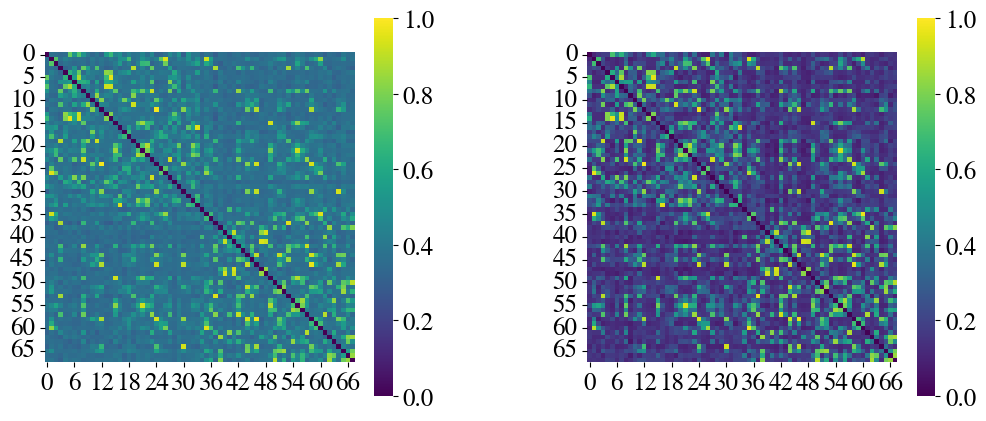

In [38]:
paras1 = edict(paras.copy())
paras1.nepoch = 1
paras2 = edict(paras.copy())
paras2.nepoch = 10

mat1 = get_fc(data, paras1);
mat2 = get_fc(data, paras2);
plt.figure(figsize=[12, 5])
plt.subplot(121)
sns.heatmap(mat1, square=True, vmax=1, vmin=0, cbar=True, cmap="viridis")
plt.subplot(122)
sns.heatmap(mat2, square=True, vmax=1, vmin=0, cbar=True, cmap="viridis")


## Save it

In [7]:
def _get_filename(params):
    keys = sorted(list(params.keys()))
    fil_name= '_'.join(f"{k}-{params[k]}" for k in keys)
    return fil_name

In [12]:
paras = edict()
paras.bd = "beta_l"
paras.fc_type = "coh"
paras.f_skip = 0
paras.nepoch = 10

for sub_ix in range(36):
    data = ind_ts[:, :, sub_ix];
    mat = get_fc(data, paras)
    fold_name = _get_filename(paras)
    fil_name = RES_ROOT/("emp_fcs/"+fold_name +f"/sub{sub_ix}.pkl")
    save_pkl(fil_name, mat)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..5.998s for estimation (3600 points)
    frequencies: 13.0Hz..20.0Hz (43 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..10
    assembling connectivity matrix
[Connectivity computation done]
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/emp_fcs/bd-beta_l_f_skip-0_fc_type-coh_nepoch-10
Create a folder /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/emp_fcs/bd-beta_l_f_skip-0_fc_type-coh_nepoch-10
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/emp_fcs/bd-beta_l_f_skip-0_fc_type-coh_nepoch-10/sub0.pkl
Connectivity computation...
only using indi

only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..5.998s for estimation (3600 points)
    frequencies: 13.0Hz..20.0Hz (43 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..10
    assembling connectivity matrix
[Connectivity computation done]
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/emp_fcs/bd-beta_l_f_skip-0_fc_type-coh_nepoch-10/sub12.pkl
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..5.998s for estimation (3600 points)
    frequencies: 13.0Hz..20.0Hz (43 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics w

    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..10
    assembling connectivity matrix
[Connectivity computation done]
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/emp_fcs/bd-beta_l_f_skip-0_fc_type-coh_nepoch-10/sub24.pkl
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..5.998s for estimation (3600 points)
    frequencies: 13.0Hz..20.0Hz (43 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..10
    assembling connectivity matrix
[Connectivity computation done]
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/emp_fcs/bd-be

In [30]:
paras1 = edict()
paras1.bd = "alpha"
paras1.fc_type = "coh"
paras1.f_skip = 0
paras1.nepoch = 10

paras2 = edict()
paras2.bd = "alpha"
paras2.fc_type = "coh"
paras2.f_skip = 0
paras2.nepoch = 1

data = ind_ts[:, :, 0];
mat1 = get_fc(data, paras1)
mat2 = get_fc(data, paras2);


Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..5.998s for estimation (3600 points)
    frequencies: 8.0Hz..12.0Hz (25 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..10
    assembling connectivity matrix
[Connectivity computation done]
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..59.998s for estimation (36000 points)
    frequencies: 8.0Hz..12.0Hz (240 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..1
    assembling connectivity matrix
[Connectivity computatio

<AxesSubplot:title={'center':'1 Epoch'}>

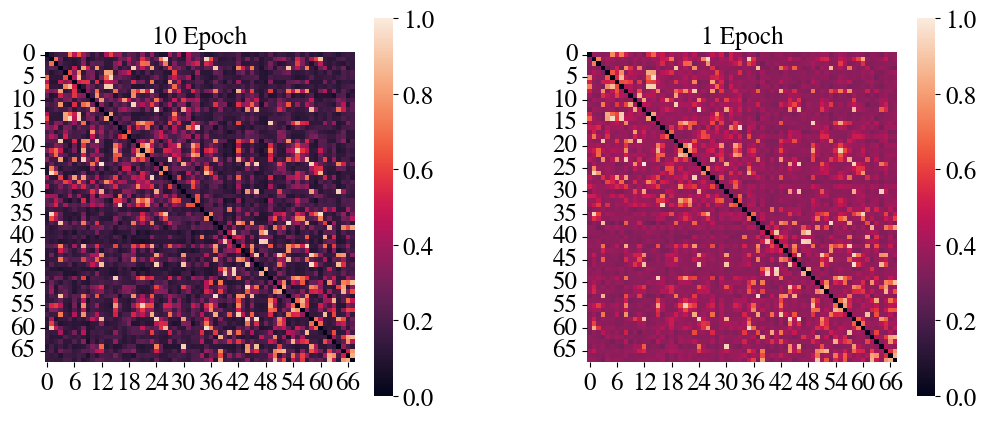

In [31]:
plt.figure(figsize=[12, 5])
plt.subplot(121)
plt.title("10 Epoch")
sns.heatmap(mat1, square=True, vmin=0, vmax=1)
plt.subplot(122)
plt.title("1 Epoch")
sns.heatmap(mat2, square=True, vmin=0, vmax=1)